In [1]:
import pickle
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from modt.modt import MoDT
from modt._initialization import *
from modt.visualization import *
from modt.utility import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 12

COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR

In [2]:
#data_input = pickle.load(open("../datasets/generated7_input.np", "rb"))
#data_target = pickle.load(open("../datasets/generated7_target.np", "rb"))
data_input = pickle.load(open("../datasets/steel_input.pd", "rb"))
data_target = pickle.load(open("../datasets/steel_target.pd", "rb"))
parameters = {
    "X": data_input,
    "y": data_target,
    "n_experts": 3,
    "iterations": 100,
    "max_depth": 2,
    "init_learning_rate": 100,
    "learning_rate_decay": 0.995,
    "initialization_method": "random",
    "use_2_dim_gate_based_on": "feature_importance_lda",
    "save_likelihood": False,
    }

parameters_fit = {
    "optimization_method": "least_squares_linear_regression",
    "early_stopping": False,
    }

modt = MoDT(**parameters)
#modt.fit(**parameters_fit)

## Estimate n experts using BIC

C:\Users\Robert\Anaconda3\envs\MA1\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


Duration: 0.7258995000000001
N_expert tested: range(1, 10)
BIC: [ -17836.55  -72318.48  -95942.22  -93043.47 -101352.64 -112762.65
 -109790.5  -112007.13 -110242.68]
BIC %:  [0.02 0.09 0.12 0.11 0.12 0.14 0.13 0.14 0.13]
Max BIC for expert: 6


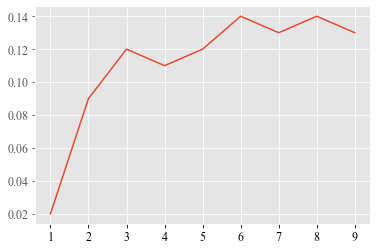

In [3]:
bic = modt.estimate_n_experts(range(1, 10), return_array=True)
plt.plot(range(1, 10), bic)

## Estimate n experts by (simple) testing

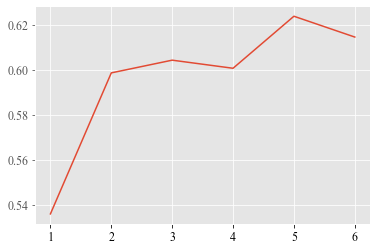

In [4]:
train_accuracies = []
for n_experts in range(1,7):
    parameters["n_experts"] = n_experts
    modt = MoDT(**parameters)
    modt.fit(**parameters_fit)
    train_accuracies.append(modt.score_internal_disjoint())
    #print(modt.n_experts)
plt.plot(range(1, 7), train_accuracies)    

In [5]:
parameters = {
    "X": data_input,
    "y": data_target,
    "n_experts": 4,
    "iterations": 100,
    "max_depth": 2,
    "init_learning_rate": 100,
    "learning_rate_decay": 0.995,
    "initialization_method": "random",
    "use_2_dim_gate_based_on": "feature_importance_lda",
    "save_likelihood": True,
    }

parameters_fit = {
    "optimization_method": "least_squares_linear_regression",
    "early_stopping": False,
    }

modt = MoDT(**parameters)
modt.fit(**parameters_fit)

Min:  0.5795981452859351 Max:  0.6491499227202473
Accuracy disjoint DTs: 0.6501803194229778


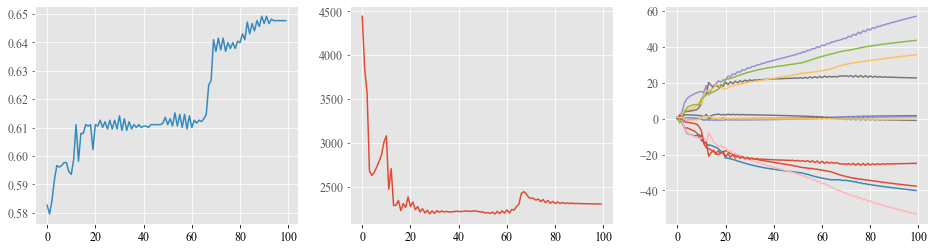

In [6]:
fig = plt.gcf()
fig.set_size_inches(16, 4)
plot_training(modt)
print("Accuracy disjoint DTs:", modt.score_internal_disjoint())

## Use Optuna to find optimized hyperparamters
Might take some time, test for one iteration first

In [7]:
df_hyperparameters = optuna_optimization(data_input,data_target,n_experts=3,max_depth=2,gating_2D=True,runs=20,only_random=True)
df_best = df_hyperparameters.sort_values(by=["user_attrs_accuracy_val"], ascending=False).head(1)
print("Best run. Training acc.: {} Test acc.: {}".format(round(df_best.user_attrs_accuracy_train.values[0],4),round(df_best.user_attrs_accuracy_val.values[0],4)))

[I 2021-08-09 19:54:32,749] A new study created in RDB with name: 2021.08.09 19:54:32 Hyper: Adhoc str


Duration: 77.82964860000001 Returning trials...
Best run. Training acc.: 0.6741 Test acc.: 0.6538


In [8]:
parameters["init_learning_rate"] = df_best.params_init_learning_rate.values[0]
parameters["learning_rate_decay"] = df_best.params_learning_rate_decay.values[0]
parameters["use_2_dim_gate_based_on"] = df_best.params_use_2_dim_gate_based_on.values[0]
parameters_fit["optimization_method"] = df_best.params_optimization_method.values[0]
parameters_fit["use_2_dim_gate_based_on"] = df_best.params_use_2_dim_gate_based_on.values[0]                                     

if df_best.params_use_2_dim_gate_based_on.values[0] == "str":
    parameters["initialization_method"] = "random"
elif df_best.params_use_2_dim_gate_based_on.values[0] == "Kmeans_init":
    parameters["initialization_method"] = Kmeans_init()
elif df_best.params_use_2_dim_gate_based_on.values[0] == "KDTmeans_init":
    alpha = df_best["params_alpha"].values[0]
    beta = df_best["params_beta"].values[0]
    gamma = df_best["params_gamma"].values[0]
    parameters["initialization_method"] = KDTmeans_init(alpha=alpha, beta=beta, gamma=gamma)
elif df_best.params_use_2_dim_gate_based_on.values[0] == "BGM_init":
    mean_precision_prior = df_best["mean_precision_prior"].values[0]      
    weight_concentration_prior_type = df_best["params_weight_concentration_prior_type"].values[0]      
    weight_concentration_prior = df_best["params_weight_concentration_prior"].values[0]      
    weight_cutoff = df_best["params_weight_cutoff"].values[0]      
    parameters["initialization_method"] = BGM_init(mean_precision_prior=mean_precision_prior,
                                                    weight_concentration_prior_type=weight_concentration_prior_type,
                                                    weight_concentration_prior=weight_concentration_prior,
                                                    weight_cutoff=weight_cutoff)
print(parameters_fit)
print(list(parameters.items())[2:])

{'optimization_method': 'ridge_regression', 'early_stopping': False, 'use_2_dim_gate_based_on': 'feature_importance_lr_max'}
[('n_experts', 4), ('iterations', 100), ('max_depth', 2), ('init_learning_rate', 104.08598636234527), ('learning_rate_decay', 0.9789559338029781), ('initialization_method', 'random'), ('use_2_dim_gate_based_on', 'feature_importance_lr_max'), ('save_likelihood', True)]


## Are the hyperparameters really better?

Min:  0.5285935085007728 Max:  0.6805770221535291
Accuracy disjoint DTs: 0.6800618238021638


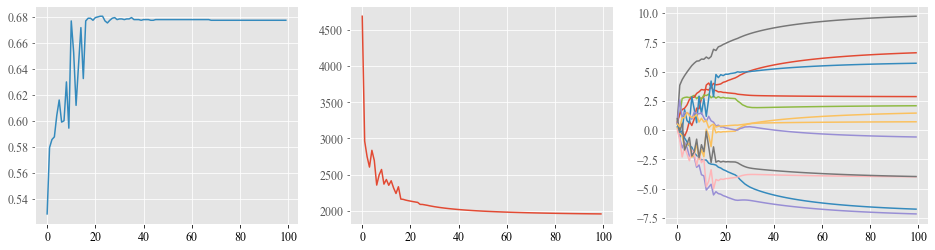

In [9]:
modt = MoDT(**parameters)
modt.fit(**parameters_fit)
fig = plt.gcf()
fig.set_size_inches(16, 4)
plot_training(modt)
print("Accuracy disjoint DTs:", modt.score_internal_disjoint())

C:\Users\Robert\Code\mixture-of-decision-trees\plotting\..\modt\visualization.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_x_ticks)
C:\Users\Robert\Code\mixture-of-decision-trees\plotting\..\modt\visualization.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_y_ticks)


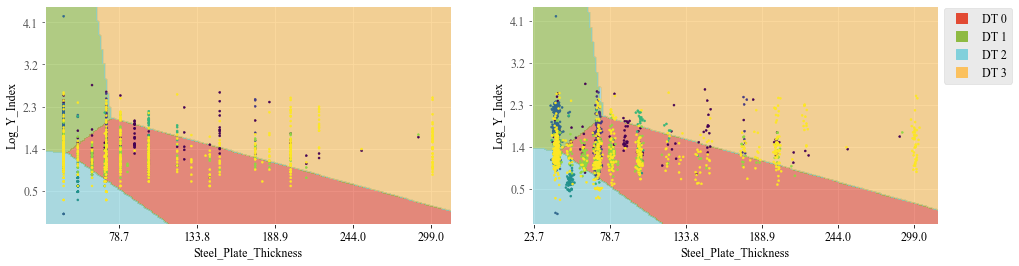

In [10]:
fig = plt.gcf()
fig.set_size_inches(16, 4)
plt.subplot(1, 2, 1)
plot_gating(modt,iteration=modt.best_iteration,title=False,axis_digits=True,inverse_transform_standardization=True,jitter=False)
plt.subplot(1, 2, 2)
plot_gating(modt,iteration=modt.best_iteration,title=False,axis_digits=True,inverse_transform_standardization=True,jitter=True,legend=True)

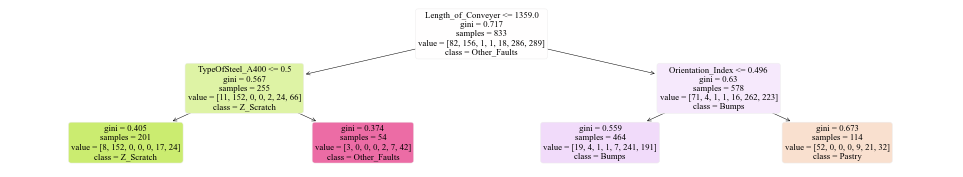

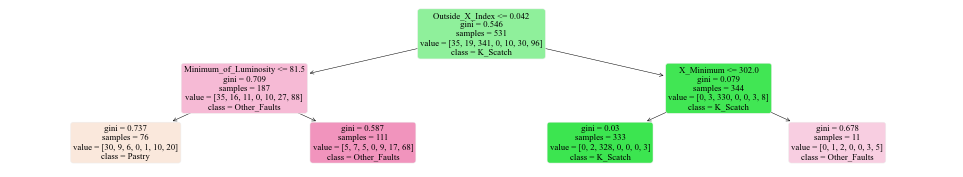

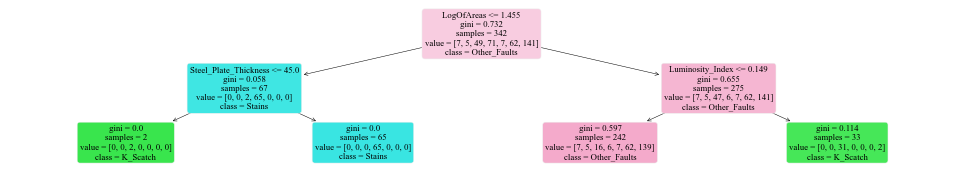

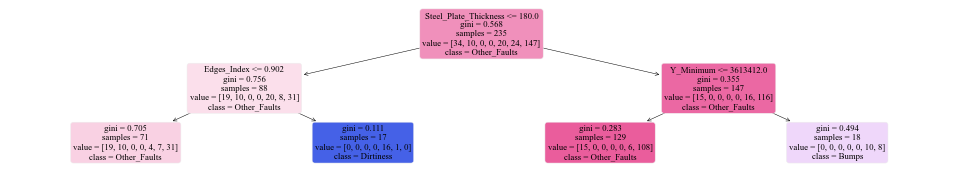

In [11]:
for expert in range(0,modt.n_experts):
    plot_disjoint_dt(modt,expert=expert,size=(17,3))

In [12]:
modt.train_disjoint_trees(modt.best_iteration, tree_algorithm="optimal_trees")

In [13]:
modt.DT_experts_alternative_algorithm[0].get_learner()

Fitted OptimalTreeClassifier:
  1) Split: Steel_Plate_Thickness < 87.5
    2) Split: Length_of_Conveyer < 1361
      3) Predict: Z_Scratch (69.68%), [16,0,0,39,12,0,154], 221 points, error 0.3032
      4) Predict: Bumps (57.94%), [219,4,1,130,24,0,0], 378 points, error 0.4206
    5) Split: Steel_Plate_Thickness < 95
      6) Predict: Pastry (94.74%), [0,0,0,1,18,0,0], 19 points, error 0.05263
      7) Predict: Other_Faults (55.35%), [51,14,0,119,28,1,2], 215 points, error 0.4465

In [14]:
modt.DT_experts_alternative_algorithm[1].get_learner()

Fitted OptimalTreeClassifier:
  1) Split: Outside_X_Index < 0.0419
    2) Predict: Other_Faults (47.06%), [27,10,11,88,35,16], 187 points, error 0.5294
    3) Predict: K_Scatch (95.93%), [3,0,330,8,0,3], 344 points, error 0.0407

In [15]:
modt.DT_experts_alternative_algorithm[2].get_learner()

Fitted OptimalTreeClassifier:
  1) Split: Pixels_Areas < 28.5
    2) Predict: Stains (97.01%), [0,0,2,0,0,65,0], 67 points, error 0.02985
    3) Split: Luminosity_Index < 0.1491
      4) Predict: Other_Faults (57.44%), [62,7,16,139,7,6,5], 242 points, error 0.4256
      5) Predict: K_Scatch (93.94%), [0,0,31,2,0,0,0], 33 points, error 0.06061

In [16]:
modt.DT_experts_alternative_algorithm[3].get_learner()

Fitted OptimalTreeClassifier:
  1) Split: Steel_Plate_Thickness < 122.5
    2) Split: TypeOfSteel_A300 < 0.5
      3) Predict: Dirtiness (80.00%), [0,20,1,4,0], 25 points, error 0.2
      4) Predict: Other_Faults (81.25%), [2,0,13,1,0], 16 points, error 0.1875
    5) Split: Steel_Plate_Thickness < 162.5
      6) Predict: Pastry (65.00%), [0,0,7,13,0], 20 points, error 0.35
      7) Predict: Other_Faults (72.41%), [22,0,126,16,10], 174 points, error 0.2759